<a href="https://colab.research.google.com/github/firarru/Text-Mining/blob/main/UTS_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Crawling Twitter**

In [1]:
# !sudo apt-get update
# !sudo apt-get install -y ca-certificates curl gnupg
# !sudo mkdir -p /etc/apt/keyrings
# !curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

# !NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

# !sudo apt-get update
# !sudo apt-get install nodejs -y

# !node -v

In [2]:
# twt_auth_token = '6829383d17b8c8b4213cee7d62ed94761c481ac7'

In [3]:
# filename = 'data_tweet.csv'

# search_keyword = 'konsumtif lang:id since:2020-01-01'
# limit = 900

# !npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twt_auth_token}

In [4]:
# import pandas as pd

# file_path = f"tweets-data/{filename}"

# df = pd.read_csv(file_path, delimiter=",")

# df

In [5]:
# df = df[['full_text', 'username']]
# df = df[df['username'] != 'grok']

In [6]:
# df.shape

In [7]:
# df.to_excel('Data Tweet Konsumtif.xlsx')

In [8]:
import pandas as pd
import numpy as np
import re
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
df = pd.read_excel('https://raw.githubusercontent.com/firarru/Text-Mining/main/Dataset/Data%20Tweet%20Konsumtif%20Label.xlsx')
df

,full_text,label
0,@gausahsokep beli soalnya abi bilang gaboleh k...,1
1,@idosdr konsumtif sesuai budget aja sih selama...,1
2,@pendicornn bisa kak asal ga teralu konsumtif,0
3,ayok konsumtif gaesss~,1
4,@inimenik jangan konsumtif ya ka,0
...,...,...
438,"jajan membuatku konsumtif, harus dikurangin ni...",0
439,"gue gak boros, gue cuma terlalu konsumtif buat...",1
440,@tempodotco gue sih berharap masyarakat indone...,0
441,gue rasa konsumtif buat nonton konser kpop tuh...,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  443 non-null    object
 1   label      443 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.1+ KB


In [11]:
df = df[['full_text', 'label']]

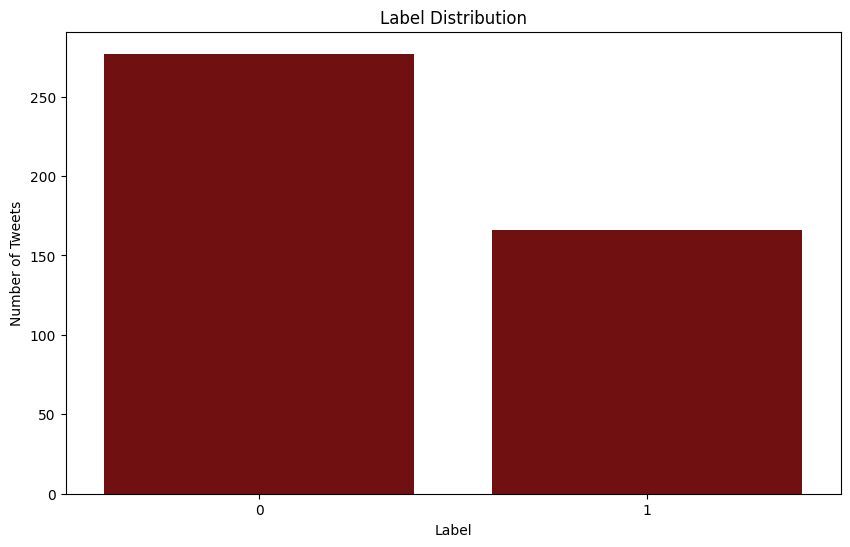

In [12]:
label_count = df['label'].value_counts()
label_count
plt.figure(figsize=(10, 6))
sns.barplot(x=label_count.index, y=label_count.values, color='maroon')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.show()

# **PREPROCESSING**

## A. CASE FOLDING

In [13]:
df['full_text'] = df['full_text'].str.lower()

## B. CLEANING

In [14]:
def cleaning_text(text) :
    text = re.sub(r'#\w+', '', text) #remove hashtag
    text = re.sub(r'\b\w*\d\w*\b', '', text) #remove words with numbers in the middle
    text = re.sub(r'@\S+', '', text) #remove mentions (@username)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove special characters
    return text

In [15]:
df['cleaning'] = df['full_text'].apply(cleaning_text)

## C. TOKENIZING

In [16]:
nltk.download('punkt_tab')
df['tokenize'] = df['cleaning'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
df.tail(5)

,full_text,label,cleaning,tokenize
438,"jajan membuatku konsumtif, harus dikurangin ni...",0,jajan membuatku konsumtif harus dikurangin nih...,"[jajan, membuatku, konsumtif, harus, dikurangi..."
439,"gue gak boros, gue cuma terlalu konsumtif buat...",1,gue gak boros gue cuma terlalu konsumtif buat ...,"[gue, gak, boros, gue, cuma, terlalu, konsumti..."
440,@tempodotco gue sih berharap masyarakat indone...,0,gue sih berharap masyarakat indonesia berhent...,"[gue, sih, berharap, masyarakat, indonesia, be..."
441,gue rasa konsumtif buat nonton konser kpop tuh...,1,gue rasa konsumtif buat nonton konser kpop tuh...,"[gue, rasa, konsumtif, buat, nonton, konser, k..."
442,gw harus kerja keras lagi karena abis konsumti...,1,gw harus kerja keras lagi karena abis konsumti...,"[gw, harus, kerja, keras, lagi, karena, abis, ..."


## D. STOPWORD

In [18]:
df_slang = pd.read_csv('https://raw.githubusercontent.com/firarru/Text-Mining/main/Dataset/slang.csv', sep=';')

In [19]:
def normalize_slang(tokens):
    normalized_tokens = []
    for word in tokens:
        formal_word = df_slang[df_slang['slang'] == word]['formal'].values
        if formal_word.size > 0:
            normalized_tokens.append(formal_word[0])
        else:
            normalized_tokens.append(word)
    return normalized_tokens

df['normalized'] = df['tokenize'].apply(normalize_slang)

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
df['filtering'] = df['normalized'].apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
custom_stopwords = set([
    'woy', 'wow', 'haha', 'huhu', 'wkwk', 'hehe', 'yah', 'loh', 'uh', 'deh', 'gaesss', 'guys','amp',
    'anjay', 'asw', 'cie', 'ckck', 'hadeh', 'anjir', 'lah', 'sih', 'dong', 'eh', 'halhal', 'dsb',
    'nih', 'deh', 'ya', 'kan', 'dong', 'mah', 'ga', 'nggak', 'gak', 'sih', 'noh', 'aduh', 'nya', 'si'
])

df['filtering'] = df['filtering'].apply(lambda x: [word for word in x if word not in custom_stopwords])

## E. STEMMING

In [22]:
pip install sastrawi

In [23]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['stemming'] = df['filtering'].apply(lambda x: [stemmer.stem(word) for word in x])

In [24]:
print(df['stemming'])

0            [beli, abi, bilang, tidak boleh, konsumtif]
1      [konsumtif, sesuai, biaya, lebih, batas, thats...
2                                [kakak, alu, konsumtif]
3                                       [ayo, konsumtif]
4                                     [konsumtif, kakak]
                             ...                        
438                     [jajan, buat, konsumtif, rangin]
439                           [boros, konsumtif, senang]
440    [harap, masyarakat, indonesia, henti, konsumti...
441    [konsumtif, nonton, konser, kpop, idol, ngadai...
442     [kerja, keras, habis, konsumtif, konser, wkwkwk]
Name: stemming, Length: 443, dtype: object


## F. TF-IDF

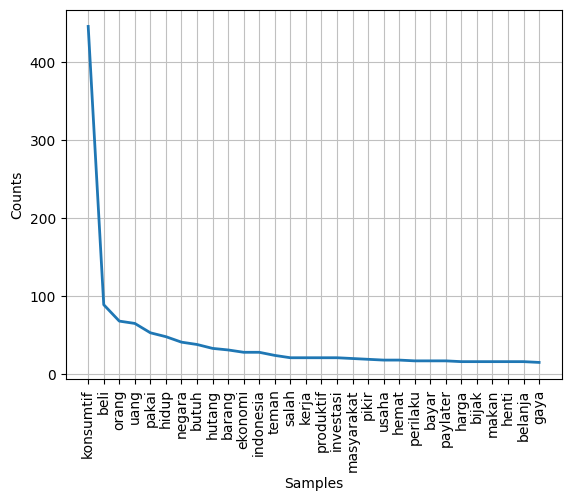

In [25]:
all_words = []
for text in df['stemming']:
    all_words.extend(text)

fdist = FreqDist(all_words)

fdist.plot(30,cumulative=False)
plt.show()

In [27]:
df['stemming'] = df['stemming'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['stemming'])

In [28]:
tfidf_array = tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()

avg_tfidf = np.mean(tfidf_array, axis=0)
df_tfidf = pd.DataFrame({
    'Kata': feature_names,
    'Rata_rata_TFIDF': avg_tfidf
})
df_tfidf.sort_values(by='Rata_rata_TFIDF', ascending=False)

,Kata,Rata_rata_TFIDF
846,konsumtif,0.084405
180,beli,0.029794
1259,orang,0.025523
1276,pakai,0.023784
1791,uang,0.022371
...,...,...
1360,podcast,0.000353
1733,tetap,0.000353
153,barista,0.000353
1524,selesai,0.000353


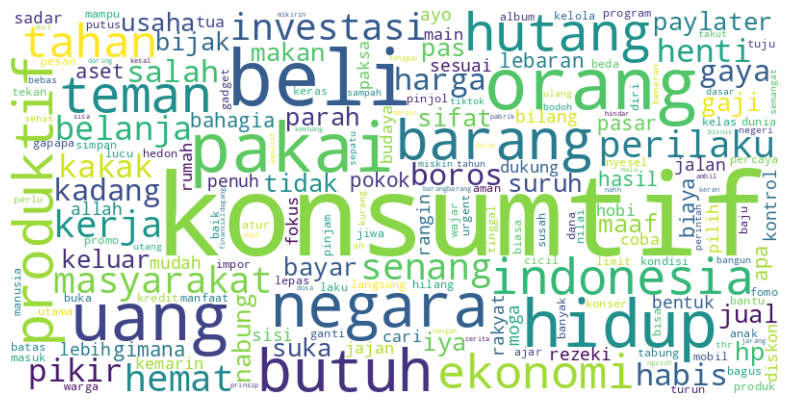

In [29]:
from wordcloud import WordCloud

wordcloud_dict = dict(zip(df_tfidf['Kata'], df_tfidf['Rata_rata_TFIDF']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Split Data**

In [30]:
X = df['stemming']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print("Training data :", X_train.shape)
print("Testing data :", X_test.shape)

Training data : (354,)
Testing data : (89,)


In [32]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# **SVM**

In [49]:
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_vec, y_train)

svm_pred = model_svm.predict(X_test_vec)

In [50]:
df_svm = pd.DataFrame({'Actual': y_test, 'Predicted': svm_pred})
df_svm

,Actual,Predicted
333,0,0
137,0,0
72,0,0
364,0,1
73,0,0
...,...,...
101,1,1
90,0,0
57,0,0
148,0,1


In [51]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.8539325842696629


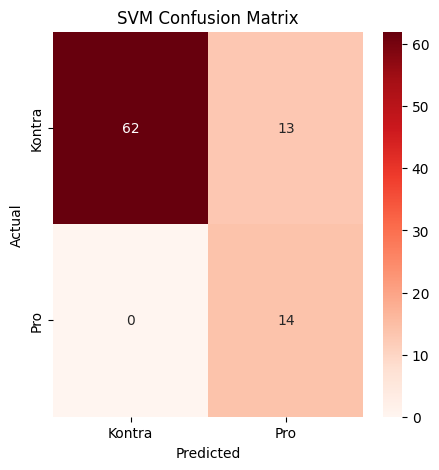

In [101]:
# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Kontra', 'Pro'],
            yticklabels=['Kontra', 'Pro'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto',1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)
grid_search.fit(X_train_vec, y_train)
print("Best hyperparameters:", grid_search.best_params_)


best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test_vec)

best_svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Best SVM Accuracy: {best_svm_accuracy}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best SVM Accuracy: 0.8426966292134831


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        75
           1       0.50      1.00      0.67        14

    accuracy                           0.84        89
   macro avg       0.75      0.91      0.78        89
weighted avg       0.92      0.84      0.86        89



# **Recurrent Neural Network**

In [40]:
# pip install tensorflow

In [41]:
# pip install keras

In [42]:
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

In [44]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=X_train_vec.shape[1]))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train_vec, y_train, epochs=10, batch_size=32, validation_data=(X_test_vec, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 994ms/step - accuracy: 0.5738 - loss: 0.6912 - val_accuracy: 0.1573 - val_loss: 0.8549
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 671ms/step - accuracy: 0.4501 - loss: 0.7333 - val_accuracy: 0.8427 - val_loss: 0.5625
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 649ms/step - accuracy: 0.5282 - loss: 0.6989 - val_accuracy: 0.8427 - val_loss: 0.6259
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 670ms/step - accuracy: 0.5742 - loss: 0.6845 - val_accuracy: 0.8427 - val_loss: 0.5931
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - accuracy: 0.5679 - loss: 0.6845 - val_accuracy: 0.8427 - val_loss: 0.6019
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 755ms/step - accuracy: 0.5707 - loss: 0.6897 - val_accuracy: 0.8427 - val_loss: 0.5709
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 648ms/step - accuracy: 0.5679 - loss: 0.6875 - val_accuracy: 0.8427 - val_loss: 0.5779
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step - accuracy: 0.5900 - loss: 0.6765 - val_accuracy

In [45]:
rnn_predict = model.predict(X_test_vec)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


In [46]:
rnn_accuracy = model.evaluate(y_test, rnn_predict)
print(f"RNN Accuracy: {rnn_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.6928 
RNN Accuracy: [0.6927955746650696, 0.0]


In [57]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [60]:
from keras_tuner.tuners import RandomSearch

def create_model(hp):
    model_rnn = Sequential()
    model_rnn.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=X_train_vec.shape[1]))
    model_rnn.add(SimpleRNN(units=hp.Int('units', min_value=64, max_value=128, step=32)))
    model_rnn.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model_rnn.add(Dense(1, activation='sigmoid'))
    model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_rnn

tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_tuning'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [65]:
random_search_result = tuner.search(X_train_vec, y_train, epochs=10,
             batch_size=32,
             validation_data=(X_test_vec, y_test),
             verbose=1)

In [67]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best dropout: {best_hps.get('dropout_rate')}")

# Train final model dengan best params
rnn_tuning = tuner.hypermodel.build(best_hps)
rnn_tuning.fit(X_train_vec, y_train, epochs=10, validation_data=(X_test_vec, y_test))

Best units: 96
Best dropout: 0.30000000000000004
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 797ms/step - accuracy: 0.4941 - loss: 0.6941 - val_accuracy: 0.8427 - val_loss: 0.5728
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 775ms/step - accuracy: 0.5377 - loss: 0.7040 - val_accuracy: 0.8427 - val_loss: 0.5836
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - accuracy: 0.4848 - loss: 0.7063 - val_accuracy: 0.8427 - val_loss: 0.6212
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 680ms/step - accuracy: 0.5585 - loss: 0.6964 - val_accuracy: 0.8427 - val_loss: 0.6483
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 677ms/step - accuracy: 0.5381 - loss: 0.6914 - val_accuracy: 0.8427 - val_loss: 0.6225
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 668ms/step - accuracy: 0.5425 - loss: 0.7022 - val_accuracy: 0.8427 - val_loss: 0.5607
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 792ms/step - accuracy: 0.5566 - loss: 0.6996 - val_accuracy: 0.8427 - val_loss: 0.5686
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 765ms/st

In [86]:
rnn_accuracy = rnn_tuning.evaluate(X_test_vec, y_test)
print(f"RNN Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.8276 - loss: 0.6112
RNN Accuracy: [0.6069260239601135, 0.8426966071128845]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


Text(0.5, 1.0, 'RNN Confusion Matrix')

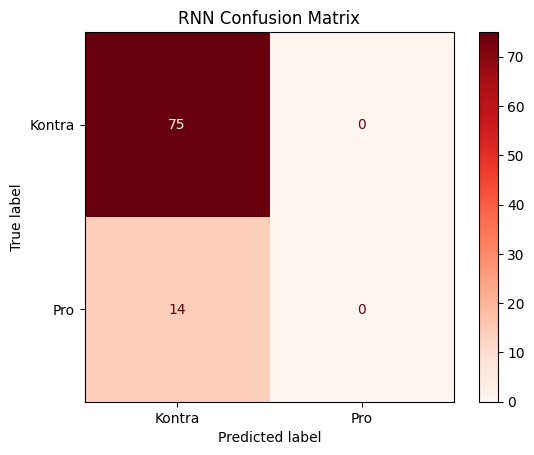

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
rnn_pred_prob = rnn_tuning.predict(X_test_vec)  # hasil probabilitas
rnn_pred = np.argmax(rnn_pred_prob, axis=1)    # ubah ke kelas prediksi

cm = confusion_matrix(y_test, rnn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Kontra', 'Pro'])
disp.plot(cmap='Reds', values_format='d')
plt.title('RNN Confusion Matrix')

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        75
           1       0.00      0.00      0.00        14

    accuracy                           0.84        89
   macro avg       0.42      0.50      0.46        89
weighted avg       0.71      0.84      0.77        89



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **XGBOOST**

In [69]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train_vec, y_train)

xgb_pred = xgb_model.predict(X_test_vec)

In [70]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy}")

XGBoost Accuracy: 0.7415730337078652


In [73]:
X_test_text = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

hasil = pd.DataFrame({
    'Tweet': X_test_text,
    'Label Asli': y_test_reset,
    'Prediksi': y_pred
})

salah_prediksi = hasil[hasil['Label Asli'] != hasil['Prediksi']]

In [74]:
print("Tweet yang salah diprediksi:")
salah_prediksi

Tweet yang salah diprediksi:


,Tweet,Label Asli,Prediksi
5,janji henti konsumtif ayo ayo,1,0
8,ayo kakak gibran bantuin donk industri kreatif...,1,0
13,teman ngontrak prioritasin hutang bentuk produ...,1,0
18,konsumtif saat nabung konser,1,0
19,konsumtif vitamin suplemen gym sehat salah,1,0
26,bilang konsumtif dukung ekonomi negara,1,0
27,negara barang hasil jual harga bagus pasar lum...,1,0
39,indonesia target pasar negara konsumtif,1,0
57,beli abi bilang tidak boleh konsumtif,1,0
62,rezeki ketuker konsumtif dosa,1,0


In [130]:
rnn_pred_prob = rnn_tuning.predict(X_test_vec)
rnn_pred = np.argmax(rnn_pred_prob, axis=1)
rnn_accuracy = accuracy_score(y_test, rnn_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
RNN Accuracy: 0.8426966292134831


In [131]:
from sklearn.metrics import confusion_matrix
svm_cm = confusion_matrix(y_test, svm_pred)
rnn_cm = confusion_matrix(y_test, rnn_pred)

print("Confusion Matrix (SVM):")
print("                Predicted")
print("               Kontra  Pro")
print(f"Actual Kontra    {svm_cm[0][0]}    {svm_cm[0][1]}")
print(f"Actual  Pro      {svm_cm[1][0]}     {svm_cm[1][1]}")
print(f'SVM Accuracy : {svm_accuracy}')
print('-----------------------------')
print("Confusion Matrix (RNN):")
print("                Predicted")
print("               Kontra  Pro")
print(f"Actual Kontra    {rnn_cm[0][0]}     {rnn_cm[0][1]}")
print(f"Actual  Pro      {rnn_cm[1][0]}     {rnn_cm[1][1]}")
print(f'RNN Accuracy : {rnn_accuracy}')

Confusion Matrix (SVM):
                Predicted
               Kontra  Pro
Actual Kontra    62    13
Actual  Pro      0     14
SVM Accuracy : 0.8539325842696629
-----------------------------
Confusion Matrix (RNN):
                Predicted
               Kontra  Pro
Actual Kontra    75     0
Actual  Pro      14     0
RNN Accuracy : 0.8426966292134831
